`2.1.2.1` was the new figures. I want to customize `fig1c` to only include the B column. Had to add a new parameter to `plot_mcmc_areas(..)`

In [21]:
PLOT_DIR='plots/2.1.2.1.1-poster/'

In [22]:
!echo mkdir -p $PLOT_DIR
!mkdir -p $PLOT_DIR

mkdir -p plots/2.1.2.1.1-poster/


In [23]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import dill

In [24]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

Imports from section 13 of `2.1.1 run same mixtures through Cibersort for comparison.ipynb`:

In [25]:
[
    merged_samples, cleaner_gt, friendly_mixture_descriptions, example_result,
    cib_class_names, rollup_groundtruth, rollupsums_df, col_order, rollups
] = pickle.load(open('/modelcache/experiments/tmp_2.1.1_plotting.pkl', 'rb'))

In [26]:
print('Cibersort Diagnostics for hyper (inserted in google doc):')
for key,row in example_result[['RMSE', 'P-value']].iterrows():
    print("mixture %d" % (key+1))
    print("{{{mix%d_rmse:%0.2f}}}" % (key+1, row['RMSE']))
    print("{{{mix%d_pval:%0.1f}}}" % (key+1, row['P-value']))
example_result[['RMSE', 'P-value']].iloc[[6,1,9]]

Cibersort Diagnostics for hyper (inserted in google doc):
mixture 1
{{{mix1_rmse:0.28}}}
{{{mix1_pval:0.0}}}
mixture 2
{{{mix2_rmse:0.34}}}
{{{mix2_pval:0.0}}}
mixture 3
{{{mix3_rmse:0.30}}}
{{{mix3_pval:0.0}}}
mixture 4
{{{mix4_rmse:0.33}}}
{{{mix4_pval:0.0}}}
mixture 5
{{{mix5_rmse:0.27}}}
{{{mix5_pval:0.0}}}
mixture 6
{{{mix6_rmse:0.34}}}
{{{mix6_pval:0.0}}}
mixture 7
{{{mix7_rmse:0.45}}}
{{{mix7_pval:0.0}}}
mixture 8
{{{mix8_rmse:0.44}}}
{{{mix8_pval:0.0}}}
mixture 9
{{{mix9_rmse:0.41}}}
{{{mix9_pval:0.0}}}
mixture 10
{{{mix10_rmse:0.49}}}
{{{mix10_pval:0.0}}}


,RMSE,P-value
6,0.452792,0.0
1,0.339896,0.0
9,0.486806,0.0


In [27]:
#sns.set_context('paper')
sns.set_style("darkgrid")

In [28]:
def savefig(fig, *args, **kwargs):
    """
    Wrap figure.savefig defaulting to tight bounding box.
    From https://github.com/mwaskom/seaborn/blob/dfdd1126626f7ed0fe3737528edecb71346e9eb0/seaborn/axisgrid.py#L1840
    """
    kwargs.setdefault("bbox_inches", "tight")
    fig.savefig(*args, **kwargs)

In [29]:
def extract_values_for_mixture_by_id(key):
    """
    key: 1-indexed, meaning mixture 1 to mixture 10
    
    based on:
    for (key, grp), \
            (_, groundtruth_base), \
            friendly_title, \
            (_, cib_vals_base), \
            (mixID_rolledup, groundtruth_rolledup), \
            (_, cib_vals_rolledup) in zip(merged_samples.groupby('sample_id'),
                                          cleaner_gt.iterrows(),
                                          #friendly_mixture_descriptions2,
                                          friendly_mixture_descriptions,
                                          example_result[cib_class_names].iterrows(),
                                          rollup_groundtruth.groupby('mixID'),
                                          rollupsums_df.iterrows()
    """
    grp = merged_samples[merged_samples['sample_id'] == key]
    groundtruth_base = cleaner_gt.iloc[key-1]
    cib_vals_base = example_result[cib_class_names].iloc[key-1]
    groundtruth_rolledup = rollup_groundtruth[rollup_groundtruth['mixID'] == key-1]
    cib_vals_rolledup = rollupsums_df.iloc[key-1]
    
    return (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup)

In [30]:
def plot_single_mixture_results(mixture_info, friendly_title):
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # http://seaborn.pydata.org/tutorial/color_palettes.html
    #sns.palplot(flatui)
    paired_colors = sns.color_palette("Paired_r", 12)
    #sns.palplot(paired_colors)
    
    (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup) = mixture_info

    with sns.plotting_context('paper'):
        f, ax = plt.subplots( figsize=(12,8))
        g = sns.boxplot(data = grp,
                       y='subset_name',
                       x='estimate',
                       ax=ax,
                       hue='type',
                       order=col_order,
                        # some additional parameters that we think may help:
                        saturation=1,
                        linewidth=1, # not sure about this one
                        dodge=False, # avoid hue nesting
                       #palette=[flatui[0], flatui[1]]
                        palette=paired_colors[0:2]
                       )
        g.set_title(friendly_title) 

        # ground truth
        gt1 = pd.DataFrame(groundtruth_base).reset_index()
        gt1.columns = ['rollup', 'estimate']
        gt1['type'] = 'subset'
        gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
        gt2['type'] = 'rollup'
        gt = pd.concat([gt1, gt2])

        sns.stripplot(
            x="estimate",
            y="rollup",
            data=gt,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(5, 1),
            #palette=[flatui[5], flatui[3]],
            palette=paired_colors[2:4],
            zorder=5,
            jitter=False,
            label='Ground Truth' # https://github.com/mwaskom/seaborn/issues/940 -- without this line, the stars aren't shown in legend entries made by "hue" param; instead you get a ton of dupe Ground Truth star labels
        )

        # add cibersort points
        cb_base = pd.DataFrame(cib_vals_base).reset_index()
        cb_base.columns = ['SubSet', 'estimate']
        cb_base['type'] = 'subset'

        cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
        cb_rolledup.columns = ['SubSet', 'estimate']
        cb_rolledup['type'] = 'rollup'

        cb = pd.concat([cb_base, cb_rolledup])
        cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

        sns.stripplot(
            x="estimate",
            y="SubSet",
            data=cb,
            hue='type',
            order=col_order,
            linewidth=0,
            size=15,
            alpha=.9,
            marker=(3, 0),
            #palette=[flatui[2], flatui[4]],
            palette=paired_colors[4:6],
            zorder=6,
            jitter=False,
            label='Cibersort' # see above again re this label parameter
        )

        g.set_xlabel('Mixture proportion')
        g.set_ylabel('Cell type')
        g.set_xbound(0, 1)

        # show legend, and subselect because stripplot adds one legend item per point it appears
        handles, labels = ax.get_legend_handles_labels()
        """
        want legend items:
        * infino samples: items 0, 1
        * ground truth stars: items 2, 3
        * cibersort triangles: items 2+len(col_order)+2, 2+len(col_order)+2+1
        """
        chosen_idx = [1,0, 2,3, 2+len(col_order)+2, 2+len(col_order)+2+1]
        chosen_handles = [handles[i] for i in chosen_idx]
        #chosen_labels = [labels[i] for i in chosen_idx]
        chosen_labels = ['Infino (sums)', 'Infino', 'Ground Truth (sums)', 'Ground Truth', 'Cibersort (sums)', 'Cibersort']
        legend = ax.legend(
            chosen_handles,
            chosen_labels,
            loc='lower right',
            frameon=True)
        frame = legend.get_frame()
        frame.set_edgecolor('red')
        frame.set_facecolor('white')

        # shade background
        #fill1 = plt.axhspan('B', 'CD4 T', facecolor='0.5', alpha=0.5)
        fill1 = plt.axhspan(-0.5, 3.5, facecolor='0.8', alpha=0.3)
        fill3 = plt.axhspan(11.5, 15.5, facecolor='0.8', alpha=0.3)

        # improve label format
        # https://stackoverflow.com/a/34426167/130164
        for label in ax.get_yticklabels():
            if label.get_text() in rollups.keys():
                label.set_size(15)
                label.set_backgroundcolor("yellow")
                label.set_weight("bold")
                label.set_color("red")
            else:
                label.set_fontstyle("italic")
                label.set_weight("bold")


        return f,ax
        

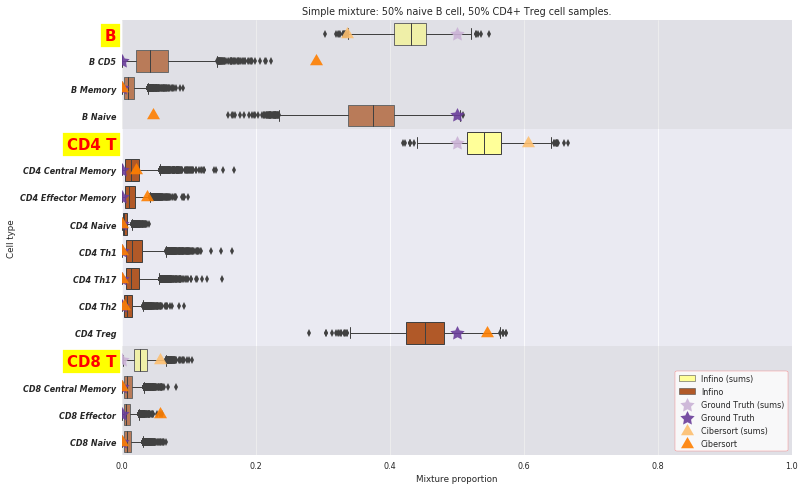

In [31]:
f,ax = plot_single_mixture_results(extract_values_for_mixture_by_id(7),
                                   'Simple mixture: 50% naive B cell, 50% CD4+ Treg cell samples.')

# New plots

['B CD5', 'B Memory', 'B Naive', 'B', 'CD4 Central Memory', 'CD4 Effector Memory', 'CD4 Naive', 'CD4 Th1', 'CD4 Th17', 'CD4 Th2', 'CD4 Treg', 'CD4 T', 'CD8 Central Memory', 'CD8 Effector', 'CD8 Naive', 'CD8 T']


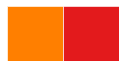

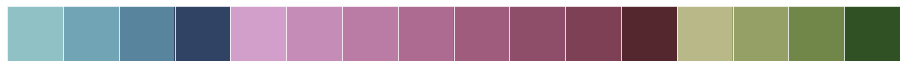

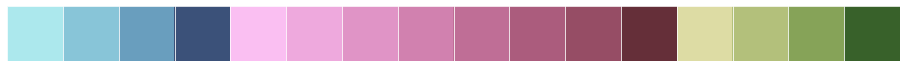

In [32]:
# set up order and colors

paired_colors = sns.color_palette("Paired_r", 12)

# colors for ground truth and cibersort overlays
sns.palplot([paired_colors[4], paired_colors[6]])

hue_order = []
built_palette = []
for r, start in zip(list(rollups), range(0,3)):
    hue_order.extend(rollups[r])
    hue_order.append(r)
    full_pal = sns.cubehelix_palette(len(rollups[r]) + 3,
                                     start=start,
                                     rot=-.25,
                                     light=.7)
    # first #subtypes colors
    built_palette.extend(full_pal[:len(rollups[r])])
    # then a darker color (but not the darkest)
    built_palette.append(full_pal[-2])
hue_order = [h.replace('_', ' ') for h in hue_order]
sns.palplot(built_palette)
print(hue_order)

color_lightening_coeff = 1.2
built_pal_lighter2 = [(np.array(i) * color_lightening_coeff).clip(0,1) for i in built_palette]
sns.palplot(built_pal_lighter2)

In [33]:
def merge_datasets_for_plots(mixID):
    mymix = extract_values_for_mixture_by_id(mixID)
    (key, grp, groundtruth_base, cib_vals_base, groundtruth_rolledup, cib_vals_rolledup) = mymix
    
    grp=grp.copy() # because going to modify
    grp['supertype'] = grp['subset_name'].apply(lambda x: 'CD4 T' if 'CD4' in x else 'CD8 T' if 'CD8' in x else 'B')

    map_row_to_ylevel = {}
    for k in rollups:
        map_row_to_ylevel[k] = 0
        for v,s in zip(rollups[k], range(1, len(rollups[k]) + 1)):
            map_row_to_ylevel[v.replace('_', ' ')] = s

    grp['ylevel'] = grp['subset_name'].apply(lambda x: map_row_to_ylevel[x])

    # add ground truth
    gt1 = pd.DataFrame(groundtruth_base).reset_index()
    gt1.columns = ['rollup', 'estimate']
    gt1['type'] = 'subset'
    gt2 = groundtruth_rolledup[['rollup', 'estimate']].copy()
    gt2['type'] = 'rollup'
    gt = pd.concat([gt1, gt2])
    gt['gt'] = gt['estimate']
    del gt['estimate']

    merged_grp = pd.merge(grp, gt, left_on='subset_name', right_on='rollup', how='left')

    # add cibersort points
    cb_base = pd.DataFrame(cib_vals_base).reset_index()
    cb_base.columns = ['SubSet', 'estimate']
    cb_base['type'] = 'subset'

    cb_rolledup = pd.DataFrame(cib_vals_rolledup).reset_index()
    cb_rolledup.columns = ['SubSet', 'estimate']
    cb_rolledup['type'] = 'rollup'

    cb = pd.concat([cb_base, cb_rolledup])
    cb.SubSet = cb.SubSet.str.replace('_', ' ') # normalize names

    cb = cb.rename(columns={'estimate': 'cb'})

    merged_grp2 = pd.merge(merged_grp, cb, left_on='subset_name', right_on='SubSet', how='left')

    # compute infino, cibersort, groundtruth relative to ground truth (i.e. 0 is gt)
    merged_grp2['estimate_rel_gt'] = merged_grp2['estimate'] - merged_grp2['gt']
    merged_grp2['cb_rel_gt'] = merged_grp2['cb'] - merged_grp2['gt']
    merged_grp2['gt_rel_gt'] = 0.0

    # turn ylevel into a categorical variable so that violinplot knows what to do with it
    merged_grp2['ylevel_str'] = merged_grp2['ylevel'].apply(lambda x: chr(65+x))
    merged_grp2['ylevel_str'].unique()
    
    return merged_grp2 # has everything for plots


In [34]:
merge_datasets_for_plots(1).head()

,sample_id,combined_iter_number,subset_name,estimate,type_x,supertype,ylevel,rollup,type_y,gt,SubSet,cb,type,estimate_rel_gt,cb_rel_gt,gt_rel_gt,ylevel_str
0,1,0,B CD5,0.017501,subset,B,1,B CD5,subset,0.0,B CD5,0.051578,subset,0.017501,0.051578,0.0,B
1,1,1,B CD5,0.024584,subset,B,1,B CD5,subset,0.0,B CD5,0.051578,subset,0.024584,0.051578,0.0,B
2,1,2,B CD5,0.005220,subset,B,1,B CD5,subset,0.0,B CD5,0.051578,subset,0.005220,0.051578,0.0,B
3,1,3,B CD5,0.001213,subset,B,1,B CD5,subset,0.0,B CD5,0.051578,subset,0.001213,0.051578,0.0,B
4,1,4,B CD5,0.047654,subset,B,1,B CD5,subset,0.0,B CD5,0.051578,subset,0.047654,0.051578,0.0,B


In [49]:
def plot_mcmc_areas(merged_dataset, relative_to_groundtruth=False,
                   legend_position='upper right'):
    """
    plot MCMC areas, perhaps relative_to_groundtruth if flag enabled
    feed in output of merge_datasets_for_plots(mixID)
    """
    
    estimate_var = 'estimate_rel_gt' if relative_to_groundtruth else 'estimate'
    gt_var = 'gt_rel_gt' if relative_to_groundtruth else 'gt'
    cb_var = 'cb_rel_gt' if relative_to_groundtruth else 'cb'
    label_cut_point = 0 if relative_to_groundtruth else .5

    with sns.plotting_context("talk"):
        with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
            g = sns.FacetGrid(merged_dataset,
                              row="ylevel", 
                              hue="subset_name",
                              col="supertype",
                              row_order=reversed(list(range(merged_dataset.ylevel.values.max()+1))),
                              hue_order=hue_order,
                              aspect=15,
                              size=.5,
                              palette=built_palette,
                              sharey=False # important -- they don't share y ranges.
                             )

            ## Draw the densities in a few steps
            # this is the shaded area
            g.map(sns.kdeplot,
                  estimate_var,
                  clip_on=False,
                  shade=True,
                  alpha=.8,
                  lw=2,
                 ) 

            # this is the dividing horizontal line
            g.map(plt.axhline, y=0, lw=2, clip_on=False, ls='dashed')
            
            ### Add label for each facet.

            def label(type_series, estimates, cut_point=.5, **kwargs):
                """
                type_series is a Series that corresponds to this facet. it will have values "subset" or "rollup"
                kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
                use estimates to find median. put rollup label on left/right based on that
                """
                type_of_label = type_series.values[0]
                color = kwargs['color']
                label = kwargs['label']
                estimate_median = estimates.median()
                ax = plt.gca() # map() changes current axis repeatedly
                if type_of_label == 'rollup':
                    plot_on_right = (estimate_median <= cut_point)
                    ax.text(
                            1 if plot_on_right else 0,
                            .2,
                            label + " (sum)", #label,
                            fontweight="bold",
                            color=color, 
                            ha="right" if plot_on_right else "left",
                            va="center", transform=ax.transAxes,
                            fontsize='x-large', #15,
                            bbox=dict(facecolor='yellow', alpha=0.3)
                           )
                else:
                    ax.text(1, .2,
                            label,
                            fontweight="bold",
                            color=color, 
                            ha="right", va="center", transform=ax.transAxes
                           )

            g.map(label, "type_x", estimate_var, cut_point=label_cut_point)
            
            ### Overlay Cibersort and Ground Truth points at the right heights.

            def get_kde_intersection_yval(x0, kde_x, kde_y):
                """
                we want to find y value at which kde line
                (defined by [kde_x, kde_y] point collection)
                intersects x=x0
                (kde_x, kde_y are numpy ndarrays)
                """
                if x0 in kde_x:
                    # the point actually is in the kde point definition!
                    return kde_y[np.where(kde_x == x0)][0]
                elif not (kde_x.min() <= x0 <= kde_x.max()):
                    # out of bounds of the kde
                    return 0
                else:
                    # need to interpolate
                    # find the two x values that most closely encircle x0
                    # then take average of their y values
                    # i.e. linear approximation 
                    diffs = np.abs(kde_x - x0)
                    idxs = np.argsort(diffs) # like argmin, but multiple outputs -- indexes for sorted order
                    argmins = idxs[:2]
                    return np.mean(kde_y[argmins])

            def plot_point(gt, scattercolor, legendlabel, plotline=True, linestyle='solid', linecolor='k', s=100, zorder=10, **kwargs):
                """
                custom function to overlay ground truth and cibersort
                method signature is: *args, **kwargs
                make sure not to have any custom kwargs named "color" or "label"
                those are passed in by default related to facet.. avoid
                """

                # get rid of "label" and "color" that seaborn passes in
                # so we don't pass double kwargs to ax.scatter
                kwargs.pop('label', None) 
                kwargs.pop('color', None) 

                ax = plt.gca()
                # passed in a gt series
                # all values are the same, since we did a left merge
                # (there's only one gt value per facet)
                xval = gt.values[0]
                
                # get y value of kde at this xval
                kde_line = ax.get_lines()[0].get_data()
                ymax = get_kde_intersection_yval(xval, kde_line[0], kde_line[1])
                # plot
                ax.scatter([xval], [ymax],
                           s=s,
                           c=scattercolor,
                           zorder=zorder,
                           clip_on=False, # means not clipped by axis limits (so we see the whole circle)
                           label=legendlabel,
                           **kwargs
                          ) 
                if plotline:
                    ax.vlines(x=xval, ymin=0, ymax=ymax, linewidths=2, colors=linecolor, linestyles=linestyle)
                    # not axvline, because ymin,ymax are in axes coordinates for axvline, not in data coordinates

            # ground truth
            g.map(plot_point,
                  gt_var,
                  scattercolor=paired_colors[4],
                  legendlabel='Ground Truth',
                  linecolor=paired_colors[4],
                  plotline=(not relative_to_groundtruth),
                  marker=(5, 1),
                  alpha=.8,
                  zorder=50,
                  s=200,
                 )
            if relative_to_groundtruth:
                # for this plot, extend ground truth line to ymax
                # axvline defaults to y \in [0,1], where that's in axes coordinates (bottom and top of plot)
                g.map(lambda *args, **kwargs: plt.gca().axvline(x=0,
                                                                c=paired_colors[4],
                                                                ls='dashed',
                                                                lw=3
                                                               )
                     )

            # cibersort 
            g.map(plot_point,
                  cb_var,
                  scattercolor=paired_colors[6],
                  linecolor=paired_colors[6],
                  legendlabel='Cibersort',
                  zorder=10,
                  alpha=.8
                 )
            
            ## Beautify the plot.

            # change x axis ranges
            if relative_to_groundtruth:
                # compute sensible xrange -- round up to nearest .25 (i.e. use math.ceil() not round())
                # we do this manually rather than setting sharex=True because want 0 to be centered (i.e. +/- same amount)
                xrng = np.ceil(max(merged_dataset.estimate_rel_gt.abs().max(),
                                   merged_dataset.cb_rel_gt.abs().max()) * 4) / 4
                g.set(
                    xlim=(-xrng - .02, xrng + .02), # so label shows up
                    xticks=np.arange(-xrng,xrng+.01,.1), # so final tick is included
                 )
            else:
                g.set(xlim=(-0.01, 1.01))

            # change y axis ranges
            g.set(ylim=(0,None)) # seems to do the trick along with sharey=False

            # Disable overlap.
            # TODO: remove this?
            # Some `subplots_adjust` line is necessary. without this, nothing appears
            g.fig.subplots_adjust(hspace=0)

            # Remove axes details that don't play will with overlap
            g.set_titles("")
            #g.set_titles(col_template="{col_name}", row_template="")
            g.set(yticks=[], ylabel='')
            g.despine(bottom=True, left=True)

            # fix x axis
            g.set_xlabels('Mixture proportion relative to ground truth' if relative_to_groundtruth else 'Mixture proportion')

            # resize
            cur_size = g.fig.get_size_inches()
            increase_vertical = 7 #4 # 3
            g.fig.set_size_inches(cur_size[0], cur_size[1] + increase_vertical)

            # legend
            handles, labels = g.fig.gca().get_legend_handles_labels()
            chosen_labels_idx = [labels.index('Ground Truth'),
                                 labels.index('Cibersort')
                                ]
            legend = g.fig.gca().legend([handles[i] for i in chosen_labels_idx],
                                        [labels[i] for i in chosen_labels_idx],
                                        loc=legend_position, #loc='upper right',
                                        frameon=True,
                                        bbox_to_anchor = (0,-0.1,1,1),
                                        bbox_transform = g.fig.transFigure
                                       )
            # without bbox_to_anchor this gets applied to upper right of the last axis
            frame = legend.get_frame()
            frame.set_edgecolor(built_palette[0])
            frame.set_facecolor('white')

            #g.fig.suptitle("Descriptive title")

            # tighten
            g.fig.tight_layout()
            # then reoverlap
            #g.fig.subplots_adjust(hspace=-.1)

            # done
            return g, g.fig

In [36]:
def plot_violins(merged_dataset):
    """
    violinplot. feed in output of merge_datasets_for_plots(mixID)
    """
    
    with sns.plotting_context("talk"):
        with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
            g = sns.FacetGrid(merged_dataset,
                              row="ylevel", # subset_name
                              hue="subset_name",
                              col="supertype",
                              row_order=reversed(list(range(merged_dataset.ylevel.values.max()+1))),
                              #row_order=hue_order,
                              hue_order=hue_order,
                              aspect=7,
                              size=1,
                              palette=built_pal_lighter2,
                              #sharex=True, # would force all xranges to be same, but we do this manually below
                              sharey=False # important -- they don't share y ranges.
                             )

            g.map_dataframe(sns.violinplot,
                x="estimate",
                y="ylevel_str",
                orient="h",
                #palette="Set3", # color comes in as "color" kwarg per map_dataframe source in axisgrid.py
                dodge=False,
                cut=0,
                bw=.2,
                scale='width',
                saturation=1, # see below, this isn't alpha. this just forces color to be plotted normally
                #alpha=.5, # doesn't do anything
                sharey=False,
                legend=False,
                clip_on=False,
                legend_out=False,
            )

            def addcustompoint(x, y, lbl, c='red', s=100, zorder=10, **kwargs):
                kwargs.pop('color', None)
                kwargs.pop('label', None)
                try: # some axes don't have any values
                    plt.scatter(x=x.values[0],
                                  y=0,
                                  s=s,
                                  c=c,
                                  label=lbl,
                                  zorder=zorder,
                                  clip_on=False,
                                  **kwargs
                                 )
                except:
                    pass

            g.map(addcustompoint, "gt", "ylevel_str", c=paired_colors[4], lbl='Ground Truth', marker=(5, 1), s=200, zorder=50, alpha=.8)
            g.map(addcustompoint, "cb", "ylevel_str", c=paired_colors[6], lbl='Cibersort', alpha=.8)


            g.map(plt.axhline, y=0, lw=2, clip_on=False, ls='dashed')

            def label(*args, **kwargs):
                """
                args[0] is a Series that corresponds to this facet. it will have values "subset" or "rollup"
                kwargs is e.g.: {'color': (0.4918017777777778, 0.25275644444444445, 0.3333333333333333), 'label': 'CD4 Treg'}
                use estimate (args[1]) to find median. put rollup label on left/right based on that
                """
                #print(args)
                #print(kwargs)
                type_of_label = args[0].values[0]
                color = np.array(kwargs['color'])

                # DARKEN COLOR
                color /= color_lightening_coeff
                color.clip(0,1)

                label = kwargs['label']
                estimate_median = args[1].median()
                ax = plt.gca() # map() changes current axis a ton
                if type_of_label == 'rollup':
                    plot_on_right = (estimate_median <= .5)
                    ax.text(
                            1 if plot_on_right else 0,
                            .2,
                            label + " (sum)", #label,
                            fontweight="bold",
                            color=color, 
                            ha="right" if plot_on_right else "left",
                            va="center", transform=ax.transAxes,
                            fontsize='x-large', #15,
                            bbox=dict(facecolor='yellow', alpha=0.3)
                           )
                else:
                    ax.text(1, .2,
                            label,
                            fontweight="bold",
                            color=color, 
                            ha="right", va="center", transform=ax.transAxes
                           )

            g.map(label, "type_x", "estimate")

            g.set(xlim=(0,1))     

            # Remove axes details that don't play will with overlap
            g.set_titles("")
            #g.set_titles(col_template="{col_name}", row_template="")
            g.set(yticks=[], ylabel='')
            g.despine(bottom=True, left=True)

            # fix x axis
            g.set_xlabels('Mixture proportion')



            # legend
            handles, labels = g.fig.gca().get_legend_handles_labels()
            chosen_labels_idx = [labels.index('Ground Truth'),
                                 labels.index('Cibersort')
                                ]
            legend = g.fig.gca().legend([handles[i] for i in chosen_labels_idx],
                                        [labels[i] for i in chosen_labels_idx],
                                        loc='upper right',
                                        frameon=True,
                                        bbox_to_anchor = (0,-0.1,1,1),
                                        bbox_transform = g.fig.transFigure
                                       )
            # without bbox_to_anchor this gets applied to upper right of the last axis, which is the CD8 T cell bottommost facet
            frame = legend.get_frame()
            frame.set_edgecolor(built_palette[0])
            frame.set_facecolor('white')

            # tighten
            g.fig.tight_layout()

            return g, g.fig

(<seaborn.axisgrid.FacetGrid at 0x7f85380a99e8>,
 <matplotlib.figure.Figure at 0x7f853e7a9fd0>)

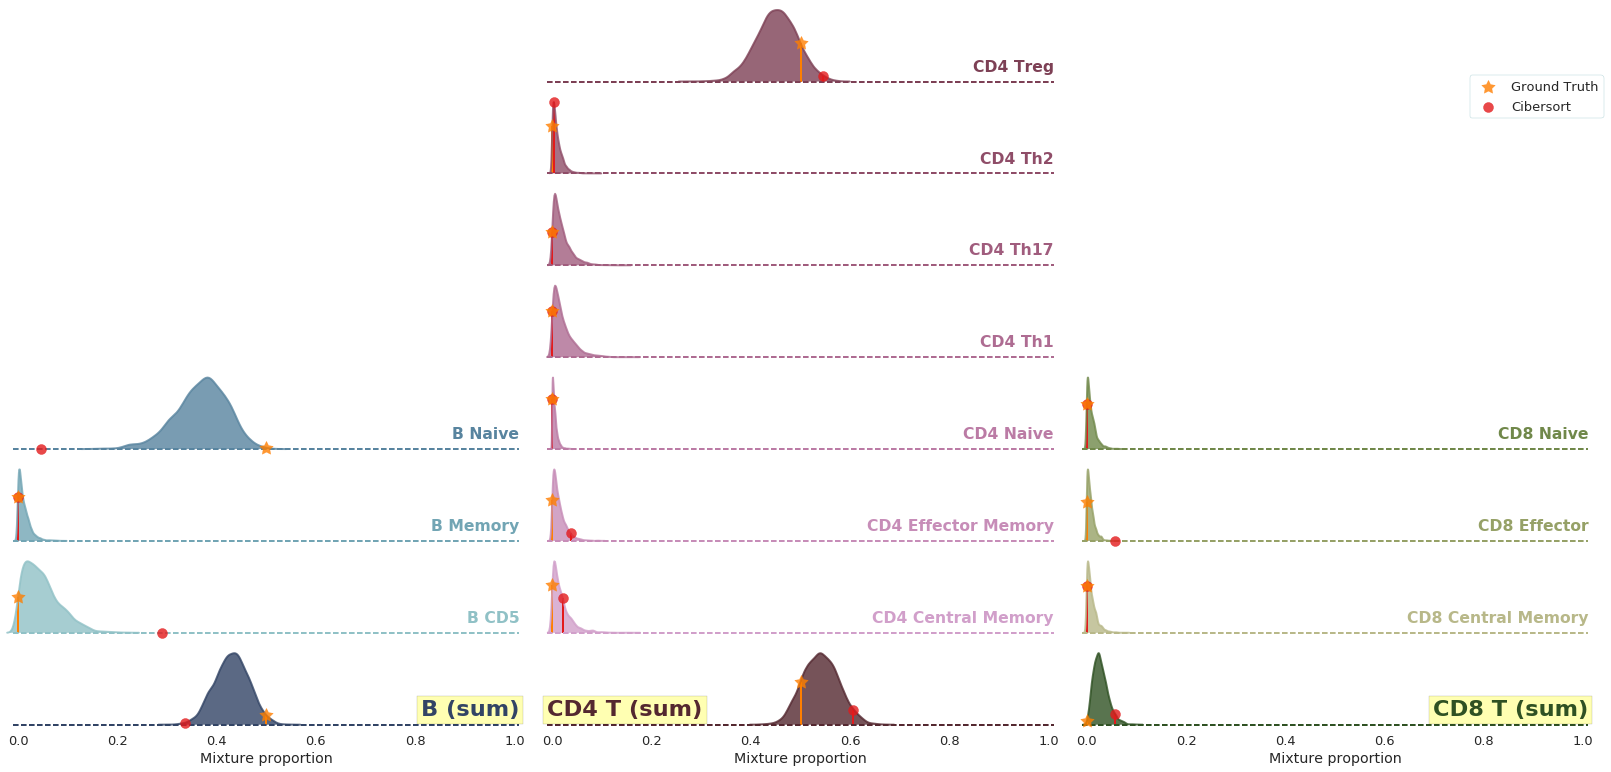

In [37]:
plot_mcmc_areas(merge_datasets_for_plots(7), relative_to_groundtruth=False)

(<seaborn.axisgrid.FacetGrid at 0x7f853bfae940>,
 <matplotlib.figure.Figure at 0x7f853c039668>)

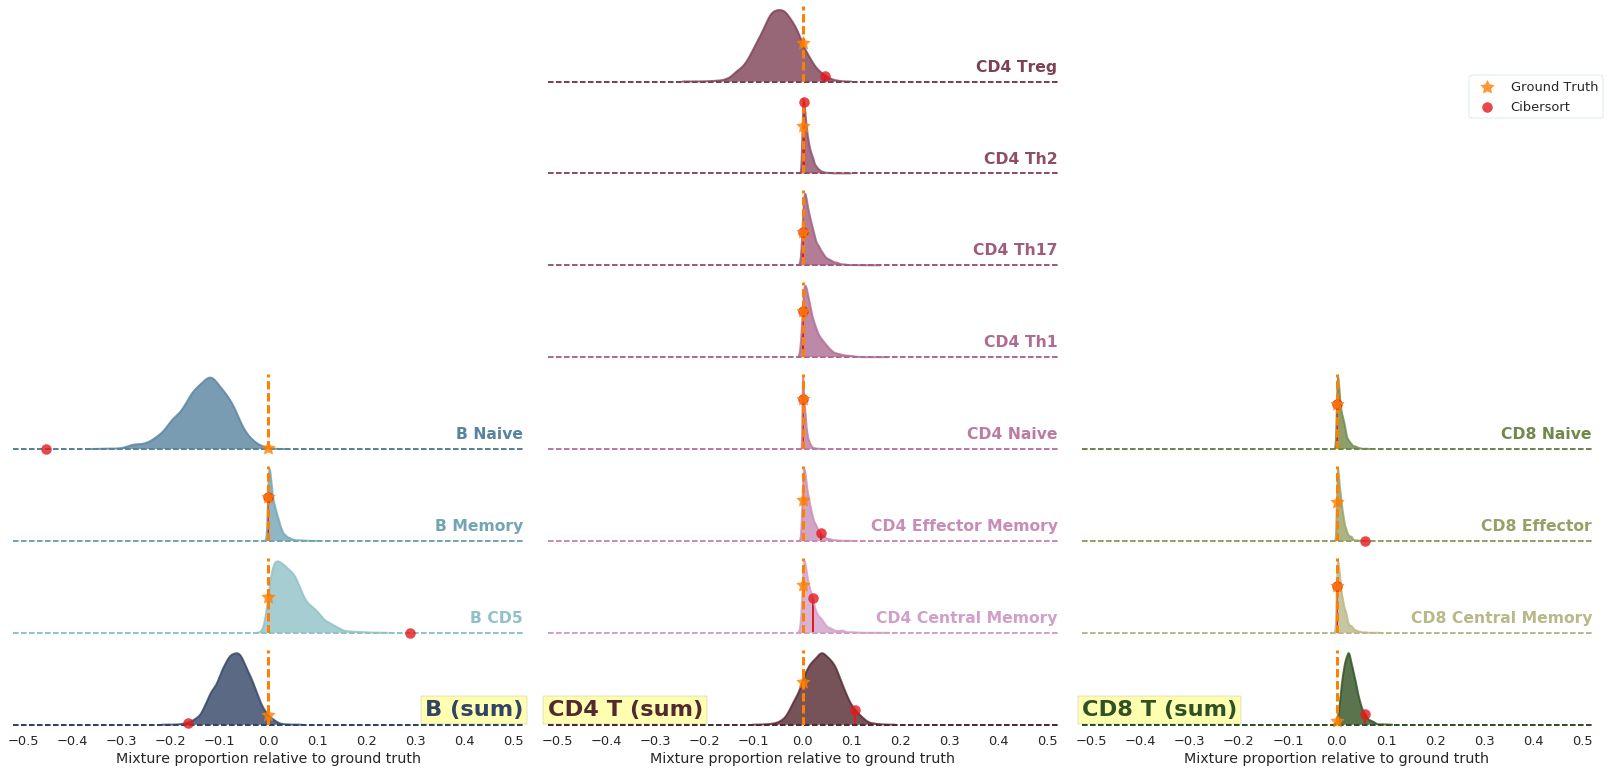

In [38]:
plot_mcmc_areas(merge_datasets_for_plots(7), relative_to_groundtruth=True)

(<seaborn.axisgrid.FacetGrid at 0x7f853b648198>,
 <matplotlib.figure.Figure at 0x7f853b6e7358>)

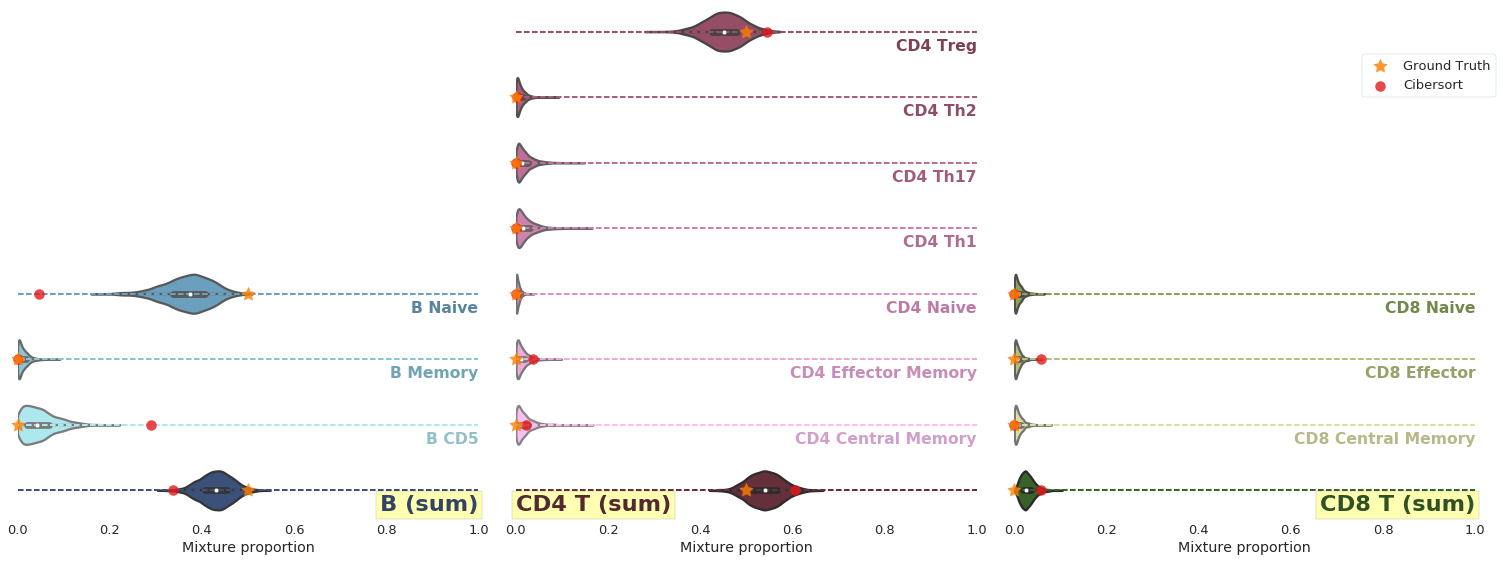

In [39]:
plot_violins(merge_datasets_for_plots(7))

# Custom fig1c for poster

Want to make fig1c only for B subtypes.

## Fig 1C: Complex mixture: 50% naive, 50% memory B cell samples.

(<seaborn.axisgrid.FacetGrid at 0x7f8529239160>,
 <matplotlib.figure.Figure at 0x7f8529686668>)

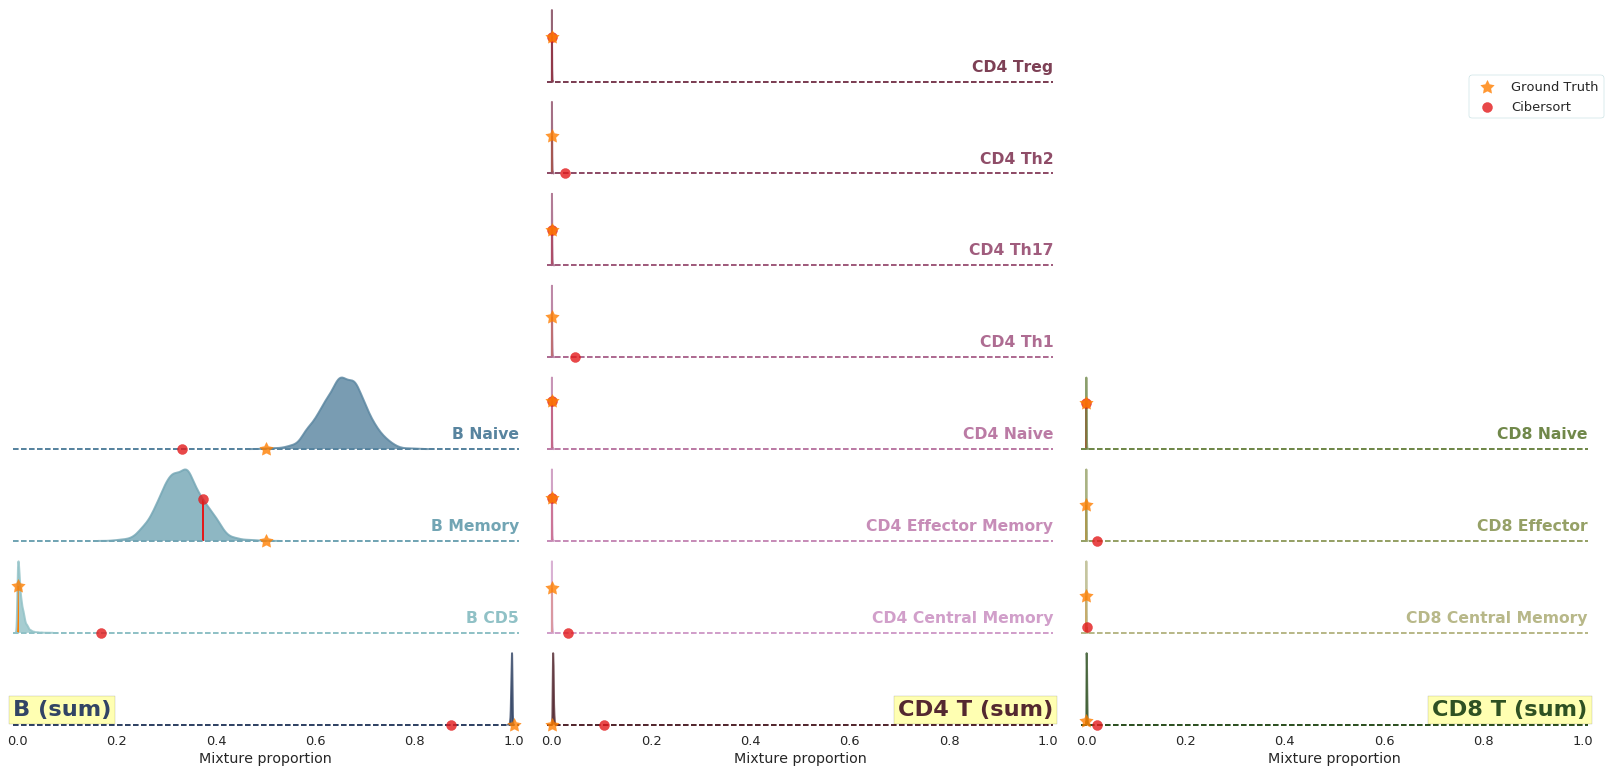

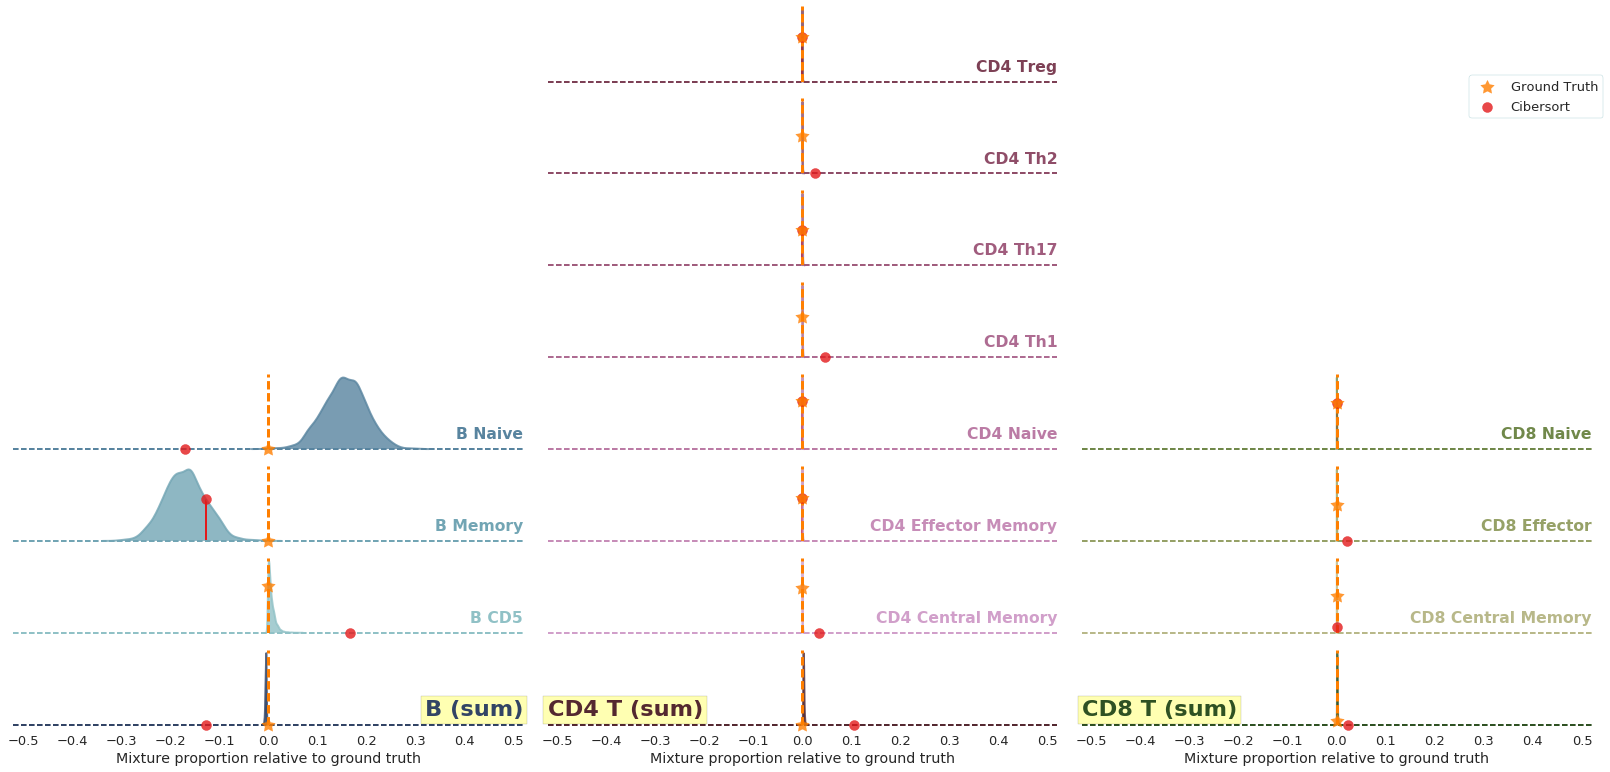

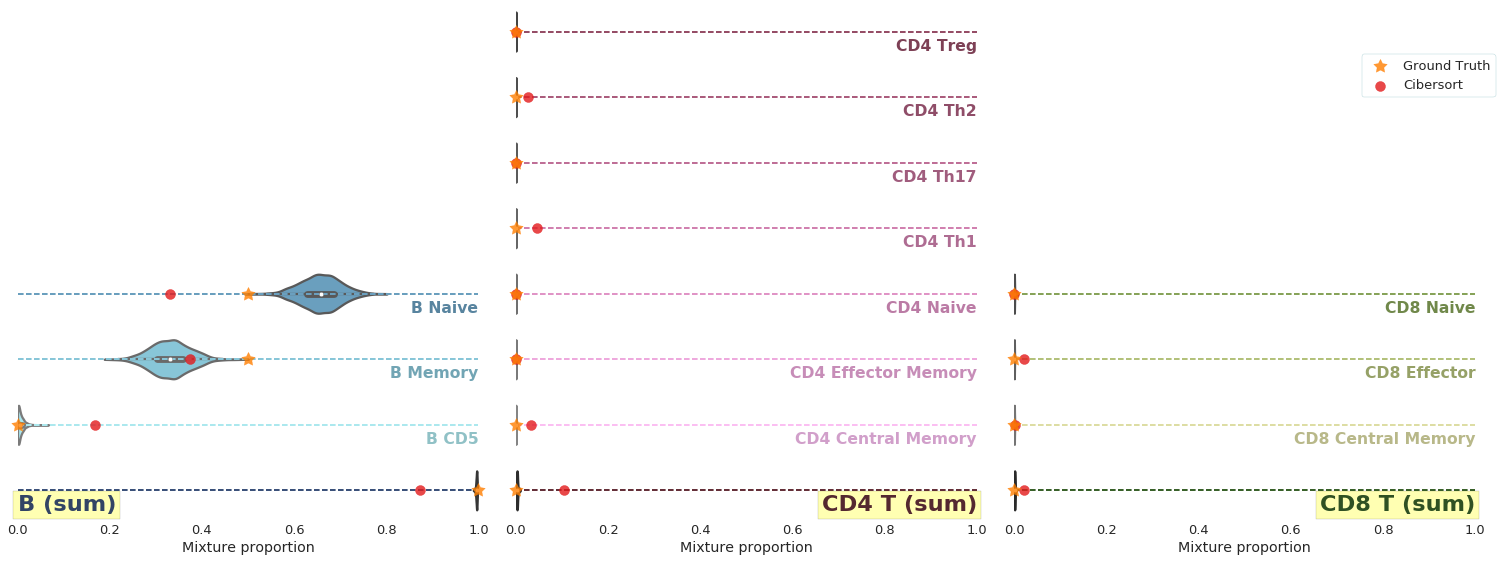

In [40]:
plot_mcmc_areas(merge_datasets_for_plots(2))

g,f = plot_mcmc_areas(merge_datasets_for_plots(2), relative_to_groundtruth=True)
# g.savefig('plots/2.1.2.1/fig1c.pdf', dpi=300)
# g.savefig('plots/2.1.2.1/fig1c.png', dpi=300)

plot_violins(merge_datasets_for_plots(2))

In [41]:
plot_df = merge_datasets_for_plots(2)
plot_df.head()

,sample_id,combined_iter_number,subset_name,estimate,type_x,supertype,ylevel,rollup,type_y,gt,SubSet,cb,type,estimate_rel_gt,cb_rel_gt,gt_rel_gt,ylevel_str
0,2,0,B CD5,0.000804,subset,B,1,B CD5,subset,0.0,B CD5,0.168064,subset,0.000804,0.168064,0.0,B
1,2,1,B CD5,0.002172,subset,B,1,B CD5,subset,0.0,B CD5,0.168064,subset,0.002172,0.168064,0.0,B
2,2,2,B CD5,0.017895,subset,B,1,B CD5,subset,0.0,B CD5,0.168064,subset,0.017895,0.168064,0.0,B
3,2,3,B CD5,0.002130,subset,B,1,B CD5,subset,0.0,B CD5,0.168064,subset,0.002130,0.168064,0.0,B
4,2,4,B CD5,0.019353,subset,B,1,B CD5,subset,0.0,B CD5,0.168064,subset,0.019353,0.168064,0.0,B


In [42]:
plot_df.supertype.value_counts()

CD4 T    32000
B        16000
CD8 T    16000
Name: supertype, dtype: int64

In [43]:
assert not plot_df.supertype.isnull().any()

In [44]:
plot_df_filtered = plot_df.loc[plot_df['supertype']=='B']
plot_df_filtered.shape, plot_df.shape

((16000, 17), (64000, 17))

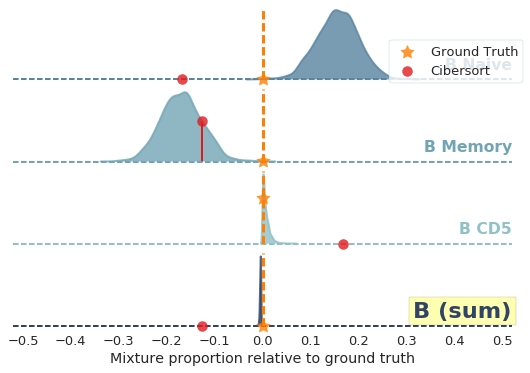

In [48]:
g,f = plot_mcmc_areas(plot_df_filtered, relative_to_groundtruth=True)
cur_size = g.fig.get_size_inches()
increase_vertical = 7 #4 # 3
g.fig.set_size_inches(cur_size[0], cur_size[1] - 4)
#g.fig.tight_layout()

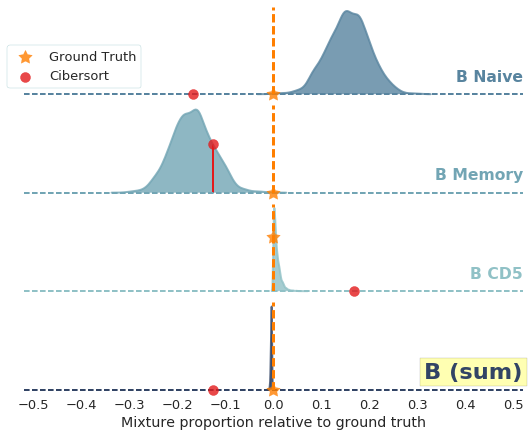

In [54]:
g,f = plot_mcmc_areas(plot_df_filtered, relative_to_groundtruth=True, legend_position='upper left')
cur_size = g.fig.get_size_inches()
g.fig.set_size_inches(cur_size[0], cur_size[1] - 3)
#g.fig.tight_layout()

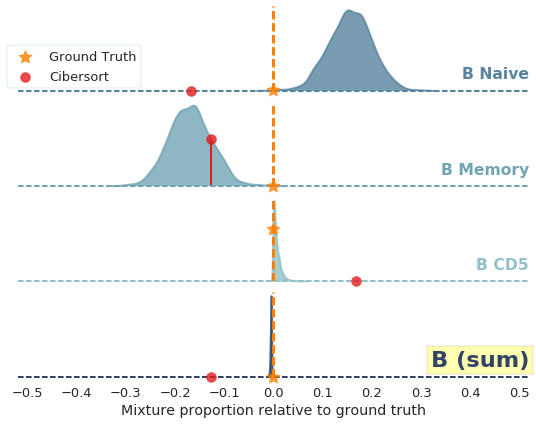

In [53]:
g,f = plot_mcmc_areas(plot_df_filtered, relative_to_groundtruth=True, legend_position='upper left')
cur_size = g.fig.get_size_inches()
g.fig.set_size_inches(cur_size[0], cur_size[1] - 3)
g.fig.tight_layout()

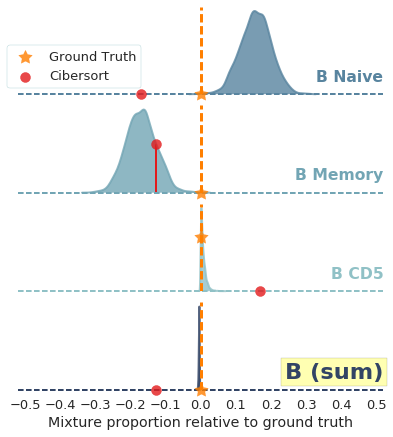

In [58]:
g,f = plot_mcmc_areas(plot_df_filtered, relative_to_groundtruth=True, legend_position='upper left')
cur_size = g.fig.get_size_inches()
g.fig.set_size_inches(cur_size[0] - 2, cur_size[1] - 3)
#g.fig.tight_layout()

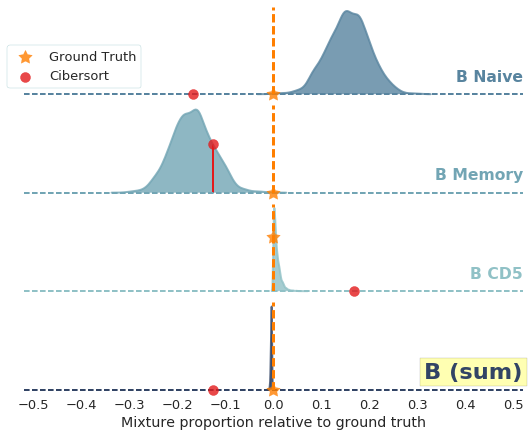

In [55]:
g,f = plot_mcmc_areas(plot_df_filtered, relative_to_groundtruth=True, legend_position='upper left')
cur_size = g.fig.get_size_inches()
g.fig.set_size_inches(cur_size[0], cur_size[1] - 3)
#g.fig.tight_layout()
g.savefig(PLOT_DIR+'fig1c.custom_poster.B_only.pdf', dpi=300)

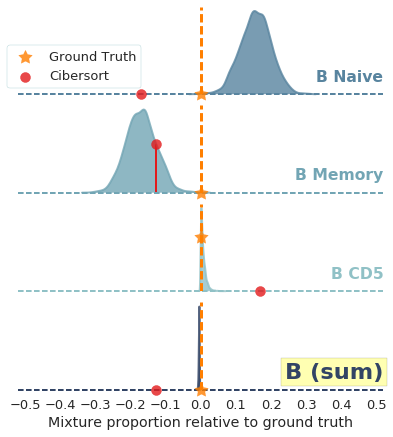

In [59]:
g,f = plot_mcmc_areas(plot_df_filtered, relative_to_groundtruth=True, legend_position='upper left')
cur_size = g.fig.get_size_inches()
g.fig.set_size_inches(cur_size[0] - 2, cur_size[1] - 3)
#g.fig.tight_layout()
g.savefig(PLOT_DIR+'fig1c.custom_poster.B_only.shrunk.pdf', dpi=300)